In [ ]:
# --- Imports: image processing, math, plotting, CSV ---

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
import csv

In [ ]:
# --- Basic config: park info & reference points ---

# Pixel coordinates for bases in the image (x, y)
home_px, first_px, third_px = (652, 1322), (969, 1317), (664, 1024)

park = "Coors Field"  # Name of the ballpark
file_name = "Coors Field.jpg" # Image file for the ballpark

warning_track_by_park = {
    "MLB": 15,
    "MiLB": 8,
    "Olympics": 20,
}

if park in warning_track_by_park: 
    warning_track = warning_track_by_park[park]
else:
    warning_track = warning_track_by_park["MLB"]

print("Using warning track =", warning_track, "feet")

# Zoom level of image
zoom = 19

In [ ]:
def grassmask(image):

    """
    Creates a binary mask for grass using HSV thresholding + morphology.
    """
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    # Rough HSV range for green
    lower_green = np.array([30, 40, 40])
    upper_green = np.array([90, 255, 255])
    
    # Threshold to get grass
    mask = cv.inRange(hsv, lower_green, upper_green)
    
    # Clean up noise with morphological operations
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    
    return mask

In [ ]:
def dirtmask(image): 

    """
    Create a binary mask for dirt (infield/warning track) from HSV.
    Returns: (dirt_mask, hsv_image)
    """

    # Two ranges to catch reddish/brown dirt tones
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV) 
    mask1 = cv.inRange(hsv, ( 0, 30, 30), ( 30, 256, 256)) #Blueish dirt
    mask2 = cv.inRange(hsv, (150, 30, 30), (180, 256, 256)) #Darker red dirt
    
    dirtmask = cv.bitwise_or(mask1, mask2) 
    
    # Morphology to remove noise and close gaps
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)) 
    dirtmask = cv.morphologyEx(dirtmask, cv.MORPH_CLOSE, kernel) 
    dirtmask = cv.morphologyEx(dirtmask, cv.MORPH_OPEN, kernel) 
    
    return dirtmask, hsv

In [ ]:
def dirtedge(dirtmask, window=(9, 9)):

    """
    Detect edges of dirt regions (e.g. warning track) using Canny.
    """
    
    blurred = cv.GaussianBlur(dirtmask, window, -1)
    edges = cv.Canny(blurred, 30, 100, apertureSize=3)
    return edges

In [ ]:
def lines(edges, lengap=(10, 5)):

    """
    Detect line segments on the edge image using HoughLinesP.
    Returns (list_of_lines, line_image).
    """

    lines = cv.HoughLinesP(
        edges,
        rho=1,
        theta=(np.pi / 180),
        threshold=40,
        lines=None,
        minLineLength=lengap[0],
        maxLineGap=lengap[1]
    )

    # Draw detected lines on a blank image
    lineim = np.zeros_like(edges)
    if lines is None:
        return lines, lineim
    for l in lines:
        l = l[0]
        cv.line(lineim, (l[0], l[1]), (l[2], l[3]), 255, 3)
    return lines, lineim

In [ ]:
# --- Load image & basic masks ---

image = cv.imread(file_name)
width, height = image.shape[:2]

# Start from dirt mask and its edges
mask, _ = dirtmask(image)
edges = dirtedge(mask)

In [ ]:
def pixel_angle_from_home(home_px, target_px):
    
    """
    Compute angle (in degrees) from home plate to a target pixel.
    Uses image coordinates (x right, y down) and returns standard angle.
    """

    xh, yh = home_px
    xt, yt = target_px
    
    # Note negative on y to convert image coordinates to standard math coordinates
    ang_deg = math.degrees(math.atan2( - (yt - yh), (xt - xh) ))
    
    return ang_deg

In [ ]:
def shortest_angle_interp(a_from, a_to, t):
    
    """
    Interpolate angles along the shortest path (handles wrap-around at 360).
    a_from, a_to in degrees; t in [0,1].
    """

    # Normalize angle into [-180, 180]
    def norm(a):
        a = (a + 180) % 360 - 180
        return a
        
    a_from_n = norm(a_from)
    a_to_n = norm(a_to)
    diff = a_to_n - a_from_n
    
    # Adjust difference to be the smaller angle (shortest rotation)
    if diff > 180:
        diff -= 360
    elif diff < -180:
        diff += 360
    
    return a_from_n + diff * t

In [ ]:
# Distance (in pixels) between home and first
pixel_dist = np.linalg.norm(np.array(home_px) - np.array(first_px))

# Feet per pixel, assuming 90ft from home to first base.
# Calibration tweak.
feet_per_pixel = (90 / pixel_dist)/1.018347812

In [ ]:
#Find the outer field boundary to use as a base "wall mask" 

grass_mask = grassmask(image)
contours, _ = cv.findContours(grass_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
wall_mask = np.zeros_like(grass_mask)

if contours:
    #Use the largest grass contour as the field boundary (ignore trees, stands, etc.)
    largest_contour = max(contours, key=cv.contourArea)
    cv.drawContours(wall_mask, [largest_contour], -1, 255, 2)
else:
    # Fallback: use dirt edges if the grass contour isn't good
    wall_mask = dirtedge(mask)

# Take the comments off of this section to see the boundary it's basing the measurements on
#debug = image.copy()
#cv.drawContours(debug, [largest_contour], -1, (0, 255, 255), 2)
#cv.imwrite("field_boundary_debug.png", debug)
#print("Saved field_boundary_debug.png (yellow = detected outer field contour)")

In [ ]:
def distance_to_wall(home_px, angle_deg, wall_mask, min_distance_px=250):
    """
    Cast a ray from home plate at a given angle until it hits the field boundary.
    Returns (distance_in_pixels, hit_point) or (None, None) if nothing valid.
    Ignores hits closer than min_distance_px to avoid infield/infield edges.
    """
    
    angle_rad = math.radians(angle_deg)
    x, y = home_px

    # Unit step in this direction
    dx = math.cos(angle_rad)
    dy = -math.sin(angle_rad)

    found = None
    max_range = 3000  # max ray length in pixels

    for i in range(1, max_range):
        xi = int(x + i * dx)
        yi = int(y + i * dy)

        # Stop if we go out of image bounds
        if xi < 0 or yi < 0 or xi >= wall_mask.shape[1] or yi >= wall_mask.shape[0]:
            break
        
        # If we hit the wall mask
        if wall_mask[yi, xi] > 0:
            
            # Skip hits too close to home (likely infield cutouts, etc.)
            if i > min_distance_px:
                found = (i, (xi, yi))
                break

    if found:
        return found
    else:
        return None, None


In [ ]:
def find_wall_after_offset(home_px, angle_deg, start_point, offset_feet, feet_per_pixel, dirt_edges, max_extra_ft=100):
    """
    After offsetting out to the warning track, keep going along the same angle
    until the next dirt edge is hit (outer wall).
    Returns (wall_point, extra_distance_in_feet) or (None, 0) if no hit.
    """
    
    angle_rad = math.radians(angle_deg)
    dx = math.cos(angle_rad)
    dy = -math.sin(angle_rad)
    
    start_x, start_y = start_point
    max_extra_px = int(max_extra_ft / feet_per_pixel)
    
    for i in range(1, max_extra_px):
        xi = int(start_x + i * dx)
        yi = int(start_y + i * dy)
        
        # Stop if we go out of bounds
        if xi < 0 or yi < 0 or xi >= dirt_edges.shape[1] or yi >= dirt_edges.shape[0]:
            break
        
        # Edge pixel found (nonzero in Canny output)
        if dirt_edges[yi, xi] > 0:
            total_extra_feet = offset_feet + (i * feet_per_pixel)
            return (xi, yi), total_extra_feet
    
    # No wall found beyond offset
    return None, None

In [14]:
def smooth_distances(distances, max_jump_ft=5):
    """
    Filters out rogue distance spikes. If a point differs too much from its neighbors,
    it’s replaced by the average of its valid neighbors.
    distances: list of (angle, distance_ft)
    """
    smoothed = distances.copy()
    
    for i in range(1, len(distances) - 1):

        if distances[i][0] < -38 or distances[i][0] > 38:
            continue
        
        prev_d = distances[i - 1][1]
        curr_d = distances[i][1]
        next_d = distances[i + 1][1]
        if curr_d is None or prev_d is None or next_d is None:
            continue

        # Check for rogue point (big deviation from neighbors)
        if abs(curr_d - prev_d) > max_jump_ft and abs(curr_d - next_d) > max_jump_ft:
            avg_neighbor = (3 * min(prev_d, next_d) + max(prev_d, next_d)) / 4
            #avg_neighbor = (prev_d + next_d) / 2
            smoothed[i] = (distances[i][0], avg_neighbor)
    return smoothed

In [15]:
vis = image.copy()
cv.circle(vis, home_px, 5, (255, 0, 0), -1)  # mark home plate

array([[[145, 165, 166],
        [139, 159, 160],
        [148, 163, 165],
        ...,
        [ 33,  41,  71],
        [ 29,  37,  67],
        [ 31,  39,  69]],

       [[138, 156, 157],
        [138, 156, 157],
        [145, 160, 162],
        ...,
        [ 27,  34,  67],
        [ 22,  29,  62],
        [ 23,  30,  63]],

       [[144, 159, 162],
        [141, 156, 159],
        [143, 158, 161],
        ...,
        [ 22,  26,  61],
        [ 14,  20,  55],
        [ 18,  24,  59]],

       ...,

       [[ 70,  53,  57],
        [112,  97, 101],
        [152, 135, 139],
        ...,
        [  0,   2,  23],
        [  0,   0,  19],
        [  0,   1,  22]],

       [[ 62,  46,  53],
        [104,  90,  96],
        [139, 124, 128],
        ...,
        [  0,   0,  19],
        [  0,   0,  17],
        [  1,   2,  22]],

       [[ 51,  37,  43],
        [ 80,  66,  72],
        [109,  95,  99],
        ...,
        [  0,   1,  20],
        [  1,   0,  20],
        [  8,   7,  27]]

In [16]:
angle_first_img = pixel_angle_from_home(home_px, first_px)
angle_third_img = pixel_angle_from_home(home_px, third_px)

# This was used for testing, feel free to remove the comment if you wish to check

#print(f"Image-angle to FIRST base: {angle_first_img:.2f}°")
#print(f"Image-angle to THIRD base: {angle_third_img:.2f}°")

# draw line from home to first/third base in light blue
cv.line(vis, home_px, first_px, (255,165,0), 2)
cv.line(vis, home_px, third_px, (255,165,0), 2)

array([[[145, 165, 166],
        [139, 159, 160],
        [148, 163, 165],
        ...,
        [ 33,  41,  71],
        [ 29,  37,  67],
        [ 31,  39,  69]],

       [[138, 156, 157],
        [138, 156, 157],
        [145, 160, 162],
        ...,
        [ 27,  34,  67],
        [ 22,  29,  62],
        [ 23,  30,  63]],

       [[144, 159, 162],
        [141, 156, 159],
        [143, 158, 161],
        ...,
        [ 22,  26,  61],
        [ 14,  20,  55],
        [ 18,  24,  59]],

       ...,

       [[ 70,  53,  57],
        [112,  97, 101],
        [152, 135, 139],
        ...,
        [  0,   2,  23],
        [  0,   0,  19],
        [  0,   1,  22]],

       [[ 62,  46,  53],
        [104,  90,  96],
        [139, 124, 128],
        ...,
        [  0,   0,  19],
        [  0,   0,  17],
        [  1,   2,  22]],

       [[ 51,  37,  43],
        [ 80,  66,  72],
        [109,  95,  99],
        ...,
        [  0,   1,  20],
        [  1,   0,  20],
        [  8,   7,  27]]

In [ ]:
distances = []
for theta_logical in range(-45, 46):

    t = (theta_logical + 45) / 90.0

    theta_image = shortest_angle_interp(angle_third_img, angle_first_img, t)
    
    min_distance_ft = 275  # ignore anything within X feet, done to prevent the in/outfield boundary confusion
    min_distance_px = int(min_distance_ft / feet_per_pixel)
    
    d_pix, hit_point = distance_to_wall(home_px, theta_image, wall_mask, min_distance_px)
    
    if d_pix is not None:
        # Original distance
        d_feet = d_pix * feet_per_pixel
        
        # Add feet offset
        # Warning track would have been 15 initially 
        d_feet_adjusted = d_feet + warning_track   
        
        # Store the adjusted distance in the CSV
        distances.append((theta_logical, d_feet_adjusted))
    
        # Step 1: extend to the end of the warning track (offset)
        # Again, the 15 switched to warning_track instead
        angle_rad = math.radians(theta_image)
        extra_px = int(warning_track / feet_per_pixel)
        offset_end = (
            int(hit_point[0] + extra_px * math.cos(angle_rad)),
            int(hit_point[1] - extra_px * math.sin(angle_rad))
        )
        
        # Step 2: find the next dirt edge (outer wall)
        # Again, the 15 replaced with warning_track variable
        wall_point, total_extra_feet = find_wall_after_offset(
            home_px, theta_image, offset_end, warning_track, feet_per_pixel, edges
        )
        
        if wall_point is not None:
            total_distance = d_feet + total_extra_feet
            distances[-1] = (theta_logical, total_distance)
            
            # Draw the full line from home to wall in green
            cv.line(vis, home_px, wall_point, (0, 255, 0), 1)
            cv.circle(vis, wall_point, 3, (0, 255, 0), -1)
            
            txt_pos = (wall_point[0] + 4, wall_point[1] - 4)
            cv.putText(vis, f"{int(round(total_distance))}ft", txt_pos, cv.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 1, cv.LINE_AA)
        
        else:
            # Fallback visualization: yellow line for offset only
            cv.line(vis, home_px, offset_end, (0, 255, 255), 1)
            cv.circle(vis, offset_end, 3, (0, 255, 255), -1)


    else:
        # If it doesn't hit a wall
        ang_rad = math.radians(theta_image)
        end = (int(home_px[0] + 1500 * math.cos(ang_rad)),
               int(home_px[1] - 1500 * math.sin(ang_rad)))
        cv.line(vis, home_px, end, (0, 0, 255), 1)
        distances.append((theta_logical, None))

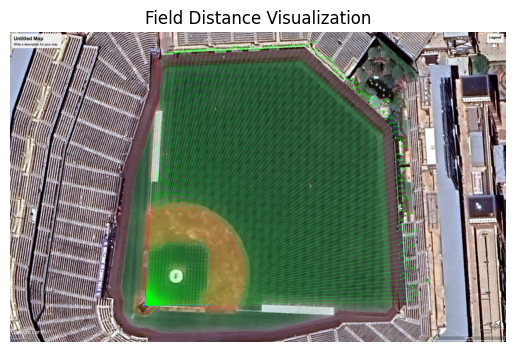

Updated visualization & CSV (angles mapped from third->first).


In [ ]:
# Smooth the distance curve to remove angle-to-angle spikes
distances = smooth_distances(distances, max_jump_ft=10)
distances = smooth_distances(distances, max_jump_ft=8)

# Saves the visualization image of all raycasts
cv.imwrite(f"{park} Visualized.png", vis)

# Write all angles + distances to CSV
with open(f"{park}.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Angle (deg)", "Distance (ft)"])
    for angle, dist in distances:
        if dist is None:
            writer.writerow([angle, "NA"])
        else:
            writer.writerow([angle, round(dist, 1)])

# Show visualization plot in notebook
plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
plt.title("Field Distance Visualization")
plt.axis("off")
plt.show()
print("Updated visualization & CSV (angles mapped from third->first).")

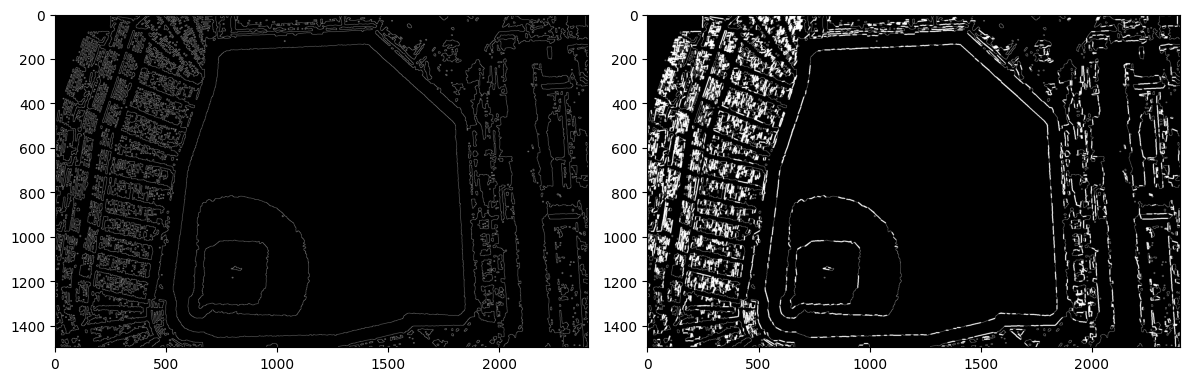

In [ ]:
"""
Dirt and grass mask sanity check

img3 = cv.imread(file_name)

dirtmask1, hsv1 = dirtmask(img3)
dirtedge1 = dirtedge(dirtmask1)
lines1, lineim1 = lines(dirtedge1)
overlay1 = cv.bitwise_or(dirtedge1, lineim1)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4), tight_layout=True)
axs[0].imshow(dirtedge1, cmap="grey")
axs[1].imshow(overlay1, cmap="grey")

"""